## Demo Notebook: Behavior clustering

In [4]:
import sys
sys.path.append('/Users/annateruel/socialhierarchy/code/')

from behavioral_clustering import sample_frames, load_features,run_umap, train_embedding_model, predict_embeddings, plot_umap_embedding, map_density

In [3]:
sp_frames = sample_frames(directory='/Users/annateruel/Desktop/features',
                          file_format='csv',
                          frames_total = 100000)

In [5]:
embedding = run_umap(sp_frames)

Running UMAP embedding...


/Users/annateruel/miniconda3/envs/umap/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP completed in 118.47 seconds.
UMAP embedding shape: (99840, 2)


In [6]:
train_embedding_model(embedding, sp_frames)

/Users/annateruel/miniconda3/envs/umap/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Training R^2: -2.99
Testing R^2: -2.14


MLPRegressor(hidden_layer_sizes=(500, 250, 125, 50), max_iter=500,
             random_state=42)

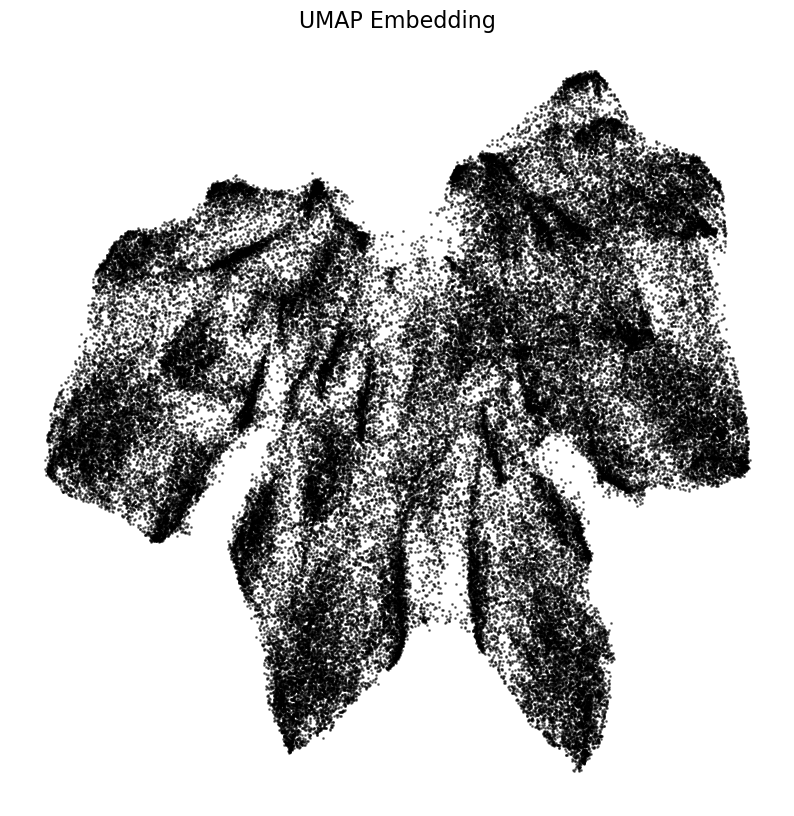

In [7]:
plot_umap_embedding(embedding)